## Install MMSegmentation
This step may take several minutes.  

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install PyTorch
# !pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113 // optional
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.1 MB/s 
     |████████████████████████████████| 237 kB 10.4 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 9.5 MB/s 
     |████████████████████████████████| 190 kB 4.9 MB/s 


In [3]:
!rm -rf mmsegmentation
!git clone https://github.com/Baimon664/mmsegmentation
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 10494, done.
remote: Counting objects: 100% (2868/2868), done.
remote: Compressing objects: 100% (2857/2857), done.
remote: Total 10494 (delta 13), reused 2851 (delta 11), pack-reused 7626
Receiving objects: 100% (10494/10494), 42.59 MiB | 35.87 MiB/s, done.
Resolving deltas: 100% (5673/5673), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 647 kB 5.2 MB/s 
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1+cu113 True
0.28.0


##Download HRnet + OCR weight for CityScape Dataset

In [5]:
import os.path as osp
import numpy as np
from PIL import Image
import mmcv
import matplotlib.pyplot as plt
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [6]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/ocrnet/ocrnet_hr48_512x1024_160k_cityscapes/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth -P checkpoints

--2022-10-06 11:47:59--  https://download.openmmlab.com/mmsegmentation/v0.5/ocrnet/ocrnet_hr48_512x1024_160k_cityscapes/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.43
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282186653 (269M) [application/octet-stream]
Saving to: ‘checkpoints/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth’

ocrnet_hr48_512x102 100%[===================>] 269.11M  8.96MB/s    in 32s     

2022-10-06 11:48:32 (8.42 MB/s) - ‘checkpoints/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth’ saved [282186653/282186653]



## Create Config

In [7]:
!pwd

/content/mmsegmentation


In [8]:
from mmcv import Config
cfg = Config.fromfile('./custom_config/hrnet_config.py')

In [9]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='CascadeEncoderDecoder',
    num_stages=2,
    pretrained='open-mmlab://msra/hrnetv2_w48',
    backbone=dict(
        type='HRNet',
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(48, 96)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(48, 96, 192)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
           

In [10]:
cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
# cfg.load_from = 'checkpoints/ocrnet_hr48_512x1024_160k_cityscapes_20200602_191037-dfbf1b0c.pth'

##Train and Evaluation

In [11]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-10-06 11:48:32,968 - mmseg - INFO - Loaded 367 images
/content/mmsegmentation/mmseg/models/backbones/hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 101/101, 7.5 task/s, elapsed: 13s, ETA:     0s

2022-10-06 11:51:37,401 - mmseg - INFO - per class results:
2022-10-06 11:51:37,404 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    Road    | 87.79 | 97.69 |
|    Misc    | 80.87 | 85.95 |
|  Building  | 78.01 | 90.81 |
|    Tree    | 82.45 |  90.1 |
|    Car     | 50.93 | 78.36 |
|  Footpath  | 17.84 | 22.21 |
| Motorcycle |  0.0  |  0.0  |
|    Pole    |  23.5 | 25.98 |
|   Person   |  0.0  |  0.0  |
|   Trash    |  0.0  |  0.0  |
| Crosswalk  |  0.0  |  0.0  |
+------------+-------+-------+
2022-10-06 11:51:37,406 - mmseg - INFO - Summary:
2022-10-06 11:51:37,411 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 87.9 | 38.31 | 44.65 |
+------+-------+-------+
2022-10-06 11:51:37,414 - mmseg - INFO - Iter(val) [101]	aAcc: 0.8790, mIoU: 0.3831, mAcc: 0.4465, IoU.Road: 0.8779, IoU.Misc: 0.8087, IoU.Building: 0.7801, IoU.Tree: 0.8245, IoU.Car: 0.5093, IoU.Footpath: 0.1784, Io

Inference with trained model

In [12]:
palette = get_palette('bangkokscapes')

In [13]:
classes = datasets[0].CLASSES

[array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])]


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

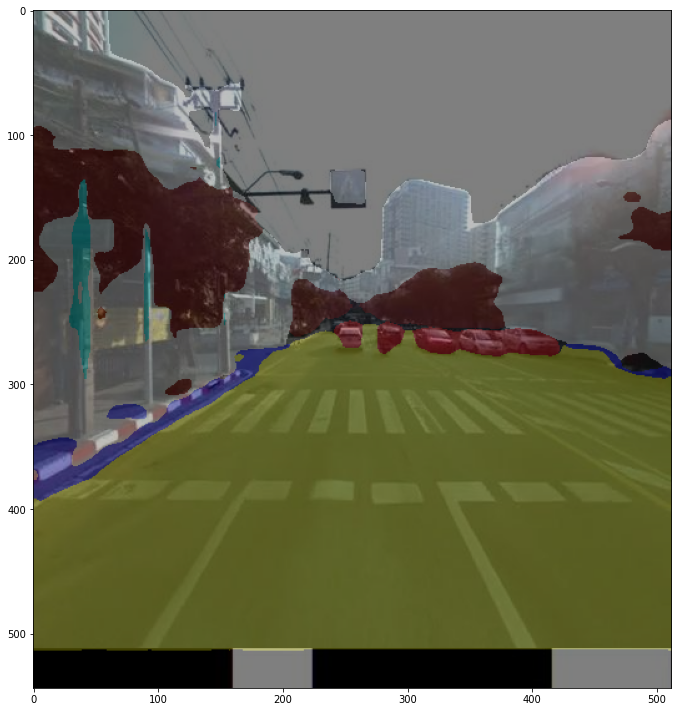

In [14]:
img = mmcv.imread('bkk-urbanscapes-complete/val/image_13_0193.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
print(result)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, get_palette('bangkokscapes'), opacity=0.5)

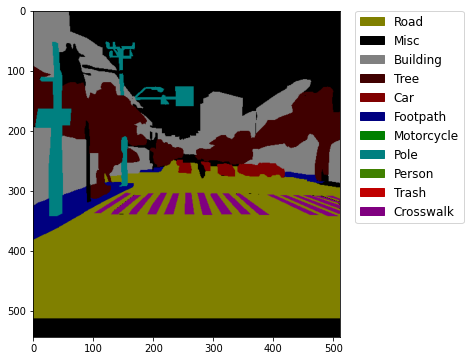

In [16]:
import matplotlib.patches as mpatches
img = Image.open('bkk-urbanscapes-complete/val_labels_new/image_13_0193.png')
plt.figure(figsize=(8, 6))
plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()